# Imports, variables, functions

In [227]:
import scipy.io
from pyedflib import highlevel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import groupby
import csv
import pickle
from scipy.signal import butter, sosfilt, sosfiltfilt, sosfreqz
from scipy.signal import freqz, iirnotch, filtfilt
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator
import random
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from scipy import signal

In [228]:
sample_rate = sampling_rate = 256
sec = 10
len_window = sample_rate*sec
overlap = 5
threshold = 2*sample_rate
sample_rate_downsample = int(0.1*sample_rate)

In [229]:
# Load annotation file
annt = scipy.io.loadmat('../raw_data/annotations_2017.mat')

In [230]:
## -- PREPROCESSING FUNCTIONS --

# Highpass filter
def highpass_filter(signals, sampling_rate, hp_frequency = 0.1):
    sos = butter(N = 3, Wn = hp_frequency, btype="highpass",fs=sampling_rate, output="sos")
    filter_hp = sosfiltfilt(sos, signals)
    return filter_hp

# Powerline filter
def notch_filter(signals, sampling_rate, notch_frequency = 50, quality_factor = 30):
    w0 = notch_frequency/(sampling_rate/2)
    b_notch, a_notch = iirnotch(w0, quality_factor)
    filter_notch = filtfilt(b_notch, a_notch, signals, axis = -1)
    return filter_notch

# Create our own scaler
class CustomTranformer(TransformerMixin, BaseEstimator): 
    # BaseEstimator generates the get_params() and set_params() methods that all Pipelines require
    # TransformerMixin creates the fit_transform() method from fit() and transform()
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.means = X.mean()
        return self
    
    def transform(self, X, y=None):
        norm_features = X - self.means
        return norm_features

# Combination of all filters and Scaler
def filter_signals(signals, sampling_rate, scaler, hp_frequency = 0.1, notch_frequency = 50, quality_factor = 30):
    filter_hp = highpass_filter(signals, sampling_rate)
    filter_notch = notch_filter(signals, sampling_rate, notch_frequency, quality_factor)
    final_signal = scaler.fit_transform(filter_notch)
    return final_signal

## -- LABEL FUNCTIONS --

# Format the EEG 
def eeg_formated(signals, names_ele):
    data_signals = signals.T # transpose the signals from datapoints
    data_signals = pd.DataFrame(data_signals) # create a pandas dataframe
    
    data_signals.columns = names_ele # rename columns
    
    return data_signals

# Format the annotations
def diagnosis(n):
    patient_A=annt["annotat_new"][0][n-1][0]
    patient_B=annt["annotat_new"][0][n-1][1]
    patient_C=annt["annotat_new"][0][n-1][2]
    
    #converting seconds to datapoints

    patient_A=patient_A.tolist()
    patient_B=patient_B.tolist()
    patient_C=patient_C.tolist()
    
    patient_A_dtp=[]
    patient_B_dtp=[]
    patient_C_dtp=[]  
    for elem in patient_A:
        for i in range(sampling_rate):
            patient_A_dtp.append(elem) 
    for elem in patient_B:
        for i in range(sampling_rate):
            patient_B_dtp.append(elem)
        
    for elem in patient_C:
        for i in range(sampling_rate):
            patient_C_dtp.append(elem)
            
    target_=pd.DataFrame({"Diagnosis A":patient_A_dtp,"Diagnosis B":patient_B_dtp,"Diagnosis C":patient_C_dtp})
    
    return target_  

# Add a time column with the seconds
def add_time(df):
    list_time=[]
    for i in range(len(df)):
        list_time.append(i//sampling_rate)
    df["time"]=list_time
    return df

# Create target variables when seizures lasts at least 10
def is_seizure(df):
    
    threshold = sampling_rate*10
    
    df['is_seizure_A'] = df["Diagnosis A"].groupby((df["Diagnosis A"] != df["Diagnosis A"].shift()).cumsum()).transform('size') * df["Diagnosis A"]
    df['is_seizure_A'] = (df['is_seizure_A'] > threshold).astype(int)
    
    df['is_seizure_B'] = df["Diagnosis B"].groupby((df["Diagnosis B"] != df["Diagnosis B"].shift()).cumsum()).transform('size') * df["Diagnosis B"]
    df['is_seizure_B'] = (df['is_seizure_B'] > threshold).astype(int)
    
    df['is_seizure_C'] = df["Diagnosis C"].groupby((df["Diagnosis C"] != df["Diagnosis C"].shift()).cumsum()).transform('size') * df["Diagnosis C"]
    df['is_seizure_C'] = (df['is_seizure_C'] > threshold).astype(int)
    
    return df 

# Create final target
def create_target(df):
    df['is_seizure_target'] = np.where(df['is_seizure_A'] + df['is_seizure_B'] + df['is_seizure_C'] >= 2, 1, 0)
    return df

# Remove useless
def remove_useless_columns(df):
    df.drop(columns=['Diagnosis A', 'Diagnosis B', 'Diagnosis C', 'is_seizure_A', 'is_seizure_B', 'is_seizure_C', 'ECG EKG', 'Resp Effort', 'time'], inplace=True)
    return df

# Final function to label
def label_data(path_raw_data, signals_preprocessed, n):
    
    signals, signal_headers, header = highlevel.read_edf(path_raw_data)
    
    names_ele = [signal_headers[iele]['label'] for iele in range(signals.shape[0])] # extract electrode names
    
    eeg_patient = eeg_formated(signals_preprocessed, names_ele) # format the ECG
    eeg_patient.rename(columns={'ECG EKG-REF':'ECG EKG', 'Resp Effort-REF':'Resp Effort'}, inplace=True)
    
    diagnosis_patient = diagnosis(n) # format the diagnosis
    
    data_patient = pd.merge(left=eeg_patient, right=diagnosis_patient, how='left', left_index=True, right_index=True) # merge ecg and diagnosis
    
    add_time(data_patient)
    is_seizure(data_patient)
    create_target(data_patient)
    remove_useless_columns(data_patient)
    
    return data_patient

def preprocess_and_label(path_raw_data, scaler, patient_number, Fournier=False):
    
    # Load raw data
    signals, signal_headers, header = highlevel.read_edf(path_raw_data)
    
    # Preprocess data 
    signals_preprocessed = filter_signals(signals, sampling_rate, scaler, hp_frequency = 0.1, notch_frequency = 50, quality_factor = 30)
    
    if Fournier == True:
        signals_preprocessed = pd.DataFrame(np.array([abs(rfft(signals_preprocessed[i])) for i in range(len(signals_preprocessed))]))
        
    # Label data
    df = label_data(path_raw_data, signals_preprocessed, patient_number)
    
    return df

## -- MODEL FUNCTIONS --

def flatten_window(window_df):
    if len(np.unique(window_df.iloc[:,-1])) == 1:
        target = window_df.iloc[0,-1]
    elif np.unique(window_df.iloc[:,-1],return_counts=True)[1][1] >= threshold:
        target = 1
    else:
        target = 0
    t_df = window_df.drop(columns = "is_seizure_target").transpose()
    flatten = pd.DataFrame(np.array(t_df).reshape(1,t_df.shape[0]*t_df.shape[1]))
    flatten["Target"] = target
    return flatten

def create_data_input(df):
    data = np.array([flatten_window(df.iloc[i:i+len_window]) for i in range(0,len(df)-len_window, overlap*sample_rate)])
    r=data.shape[0]
    c=data.shape[2]
    
    data = pd.DataFrame(data.reshape(r,c))
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    return X, y

# Data Loading and Preprocessing

In [251]:
patients = [2, 3,5]

d = []
for i in patients:
    df_i = preprocess_and_label(f"../raw_data/eeg{i}.edf", CustomTranformer(), i, Fournier=False)
    d.append(df_i)
#     d[i]= df_i
#     d[i].columns= d[i].columns.str.lower()

In [234]:
d[0]

,EEG Fp1-Ref,EEG Fp2-Ref,EEG F3-Ref,EEG F4-Ref,EEG F7-Ref,EEG F8-Ref,EEG Fz-Ref,EEG C3-Ref,EEG C4-Ref,EEG Cz-Ref,EEG T3-Ref,EEG T5-Ref,EEG T4-Ref,EEG T6-Ref,EEG P3-Ref,EEG P4-Ref,EEG Pz-Ref,EEG O1-Ref,EEG O2-Ref,is_seizure_target
0,-98.645167,-101.167312,-150.805429,-99.376346,-83.182367,-74.788670,20.013543,-143.138792,-87.463916,-77.354371,-139.180264,-9.668076,-84.621197,-61.668935,-7.265924,-127.848488,-58.116788,-140.756929,-126.694843,0
1,-98.821001,-101.178549,-152.318462,-100.563842,-81.687831,-76.560804,20.228367,-146.428835,-89.349899,-78.247286,-139.842162,-11.709217,-63.372738,-63.000002,-9.963888,-129.148470,-61.498554,-143.333635,-129.172922,0
2,-97.067707,-99.467840,-151.524433,-99.432681,-81.461237,-77.183123,19.782924,-145.092980,-88.052963,-77.638940,-157.247211,-12.517739,-78.761883,-61.846963,-11.261941,-127.605515,-61.651990,-142.162175,-126.797940,0
3,-98.678719,-101.018678,-153.656575,-102.018683,-83.169448,-79.906383,19.882898,-147.323366,-89.776689,-78.882967,-138.599045,-10.345296,-68.253342,-63.357444,-11.514185,-130.261691,-62.997133,-144.038379,-128.631423,0
4,-97.898545,-100.469111,-151.807918,-101.011273,-80.232267,-79.792650,19.633745,-145.928515,-88.713656,-77.980124,-144.491543,-10.629773,-71.803903,-64.094909,-12.265190,-128.846900,-63.588286,-142.847917,-128.002320,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962811,0.410640,0.337424,0.409646,0.360516,0.181472,-0.078290,0.213724,-0.218247,0.013076,0.287848,1.316076,0.209706,-1.219553,0.447528,0.381616,0.179538,0.205667,0.583712,0.323116,0
962812,0.070640,-0.043013,0.080348,-0.005722,0.082908,1.046529,-0.070839,0.203144,0.044084,0.097519,3.366188,-0.118990,0.325385,-0.117960,0.011960,0.009416,-0.038595,-0.281010,-0.101952,0
962813,-0.343040,-0.346732,-0.335545,-0.344599,-0.107802,0.795748,-0.242858,0.368787,0.032972,-0.203378,0.970145,-0.271169,1.442645,-0.506061,-0.353641,-0.155172,-0.213253,-0.750310,-0.372086,0
962814,-0.283654,-0.173547,-0.288245,-0.209056,-0.138058,-0.486693,-0.076326,0.062436,-0.005197,-0.216624,-2.667565,-0.047614,0.661468,-0.206150,-0.232636,-0.097024,-0.088413,-0.208427,-0.132165,0


# Downsampling

## resample

In [352]:
def downsampling(df):
    
    df_downsample = pd.DataFrame()
    all_df = pd.DataFrame()
    target_col = df.iloc[:,-1]
    
    num = int(0.1*sample_rate)
    t = 256
    
    for i, column in enumerate(df.columns[:-1]):
        df_downsample = pd.DataFrame()
        for j in range(0,len(df)-sample_rate+1,sample_rate):
            x = np.array(df.iloc[j:j+sample_rate,i])
            x_resampled = pd.DataFrame(signal.resample(x, num), index=range(int(j/10),int(j/10)+num))
            df_downsample= pd.concat([df_downsample,x_resampled])
        all_df[column] = np.array(df_downsample).reshape(1,-1)[0]
    target = []
    for t in range(0,len(target_col)-255,sample_rate):
        for n in range(num):
            target.append(target_col[t])
    all_df["target"] = target
    
    return all_df

In [353]:
d_down = []
for i in d:
    d_down.append(downsampling(i))

In [355]:
d_down[0].shape

(94025, 20)

In [361]:
25*(d[0].shape[0]/256)

94025.0

In [258]:
d_down[2]["target"].value_counts(normalize = True)

1    0.836719
0    0.163281
Name: target, dtype: float64

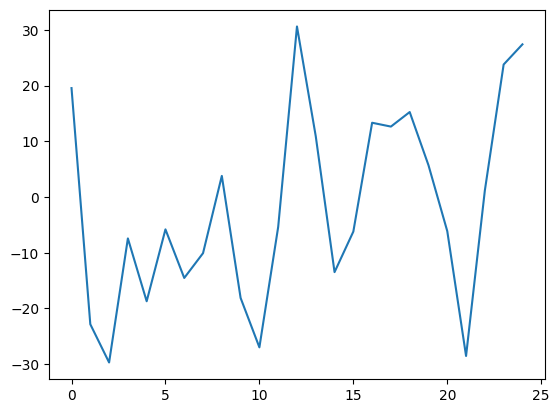

In [287]:
plt.plot(d_down[2].iloc[0:25,0])

In [259]:
d[2].iloc[:,-1].value_counts(normalize = True)

1    0.836501
0    0.163499
Name: is_seizure_target, dtype: float64

In [314]:
d[2].iloc[:,-1].value_counts(normalize = True)

1    0.836501
0    0.163499
Name: is_seizure_target, dtype: float64

## Decimate

In [261]:
from scipy.signal import decimate

In [263]:
q = 10
y = d[2].iloc[:,-1]

In [269]:
y_new = decimate(y, q)

In [271]:
y_new.shape

(98330,)

In [334]:
def downsampling(df):
    
    df_downsample = pd.DataFrame()
    all_df = pd.DataFrame()
    target_col = df.iloc[:,-1]
    q = 10
    num = 26

    
    for i, column in enumerate(df.columns[:-1]):       
        x_resampled = pd.DataFrame(decimate(df.iloc[:,i], q))
        all_df[column] = x_resampled

    target = []
    for t in range(0,len(target_col)-sample_rate,sample_rate):
        for n in range(num):
            target.append(target_col[t])
    all_df["target"] = target
    
    return all_df

In [339]:
i = 0
q = 10
num = 26
df = d[2]
target_col = df.iloc[:,-1]

In [338]:
x_resampled = pd.DataFrame(decimate(d[2].iloc[:,i], q))
x_resampled

,0
0,-0.410624
1,-18.245898
2,-30.810139
3,-9.057609
4,-15.832141
...,...
98325,-0.033407
98326,-0.031294
98327,-0.031339
98328,-0.031818


In [346]:
d_down[2].shape

(96000, 20)

In [349]:
(d[2].shape[0]/256)*25

96025.0

In [340]:
target = []

In [341]:
for t in range(0,len(target_col)-sample_rate,sample_rate):
    for n in range(num):
        target.append(target_col[t])
all_df["target"] = target

In [342]:
all_df

,target
0,1
1,1
2,1
3,1
4,1
...,...
99835,0
99836,0
99837,0
99838,0


In [325]:
99866-98330

1536

In [312]:
test_dec["target"].value_counts(normalize = True)

1    0.836719
0    0.163281
Name: target, dtype: float64

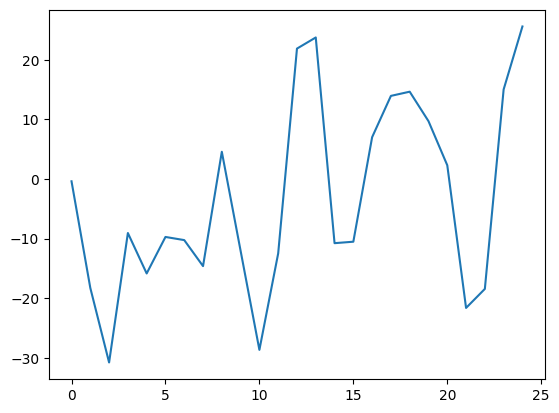

In [313]:
plt.plot(test_dec.iloc[0:25,0])

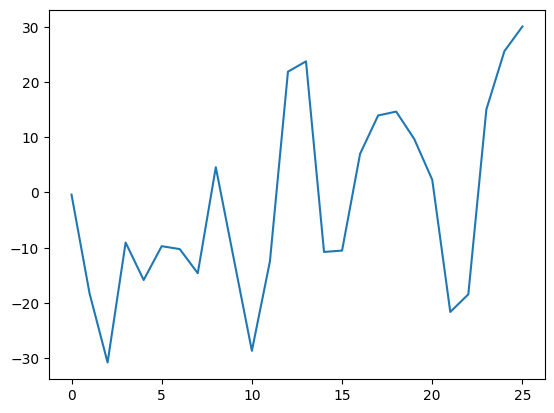

In [281]:
plt.plot(test_dec.iloc[0:26,0])

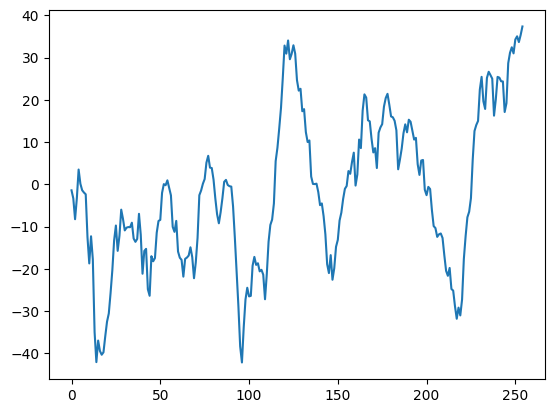

In [282]:
plt.plot(d[2].iloc[0:255,0])

In [285]:
test_dec["target"].value_counts(normalize = True)

1    0.836719
0    0.163281
Name: target, dtype: float64

In [286]:
d[2].iloc[:,-1].value_counts(normalize = True)

1    0.836501
0    0.163499
Name: is_seizure_target, dtype: float64

In [292]:
d[2]

,EEG Fp1-Ref,EEG Fp2-Ref,EEG F7-Ref,EEG F3-Ref,EEG Fz-Ref,EEG F4-Ref,EEG F8-Ref,EEG T3-Ref,EEG C3-Ref,EEG Cz-Ref,EEG C4-Ref,EEG T4-Ref,EEG T5-Ref,EEG P3-Ref,EEG Pz-Ref,EEG P4-Ref,EEG T6-Ref,EEG O1-Ref,EEG O2-Ref,is_seizure_target
0,-1.419105,17.866398,26.912596,13.849781,0.334560,-8.870927,20.188353,8.470444,-16.098475,10.602408,20.922618,22.936879,-4.219819,-8.557335,-7.741930,16.791965,15.138854,-16.910205,-9.048158,1
1,-3.318200,41.790181,53.524897,22.539651,0.112400,-16.763359,39.730104,20.065797,-32.113944,19.723380,41.087818,46.729833,-7.158927,-15.070688,-13.714219,33.680687,30.321825,-30.656286,-15.350078,1
2,-8.260964,42.491697,48.742226,10.640972,-1.428029,-11.712904,37.064375,18.978916,-29.206768,17.656212,38.100061,43.876514,-5.428389,-14.246795,-12.121809,33.083871,29.851972,-25.687254,-10.224155,1
3,-3.282774,35.593190,52.041205,19.698493,-1.821554,-12.847160,40.719617,19.530675,-32.696911,18.755420,41.574157,48.381576,-6.566801,-14.805329,-12.654931,35.169712,32.560589,-28.299376,-11.631809,1
4,3.505180,32.131439,50.848944,19.133736,-2.570428,-13.868957,37.644640,10.022557,-31.576933,18.048527,39.006783,47.168211,-9.262223,-14.579787,-12.167261,34.712738,31.528349,-28.511808,-12.419453,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983291,-0.033730,-0.064924,-0.026082,-0.034446,-0.027425,-0.026761,-0.027436,-0.012603,-0.027324,-0.024319,-0.022647,0.022053,-0.026625,-0.027575,-0.023072,-0.021672,-0.033550,-0.023223,-0.022306,0
983292,-0.023593,-0.031483,-0.022750,-0.036947,-0.028290,-0.017447,-0.017235,-0.031539,-0.025934,-0.021483,-0.009234,0.038073,-0.019041,-0.017465,-0.010821,-0.002239,0.015834,-0.001533,-0.006423,0
983293,-0.024829,0.000780,-0.031840,-0.033075,-0.034224,-0.027610,-0.026799,-0.051086,-0.032745,-0.032736,-0.026178,-0.038732,-0.028815,-0.026816,-0.026822,-0.022453,0.001434,-0.020443,-0.024631,0
983294,-0.035700,-0.010710,-0.041236,-0.028001,-0.037347,-0.043653,-0.043319,-0.045436,-0.038689,-0.043093,-0.050828,-0.106108,-0.042881,-0.043103,-0.049688,-0.055259,-0.057144,-0.054611,-0.052575,0


In [306]:
test = decimate(d[2].iloc[:,0], 10)

In [307]:
test

array([ -0.41062371, -18.2458983 , -30.8101392 , ...,  -0.03133879,
        -0.03181799,  -0.034982  ])

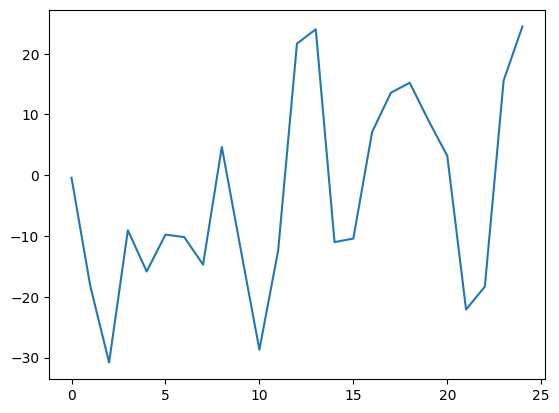

In [308]:
plt.plot(test[0:25])